In [1]:
import re
import warnings
from dataclasses import dataclass
from datetime import datetime, timezone
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score,
    classification_report, confusion_matrix, RocCurveDisplay
)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

warnings.filterwarnings("ignore")

BASE_DIR = Path(r"C:\Users\lisal\A4ESILV\Machine Learning\projet")

@dataclass
class Config:
    patched_path: str = str(BASE_DIR / "dataset_patched.csv")
    unpatched_path: str = str(BASE_DIR / "dataset_unpatched.csv")
    target_col: str = "is_kev"
    text_col: str = "description"
    date_col: str = "published"
    cvss_vec_col: str = "cvss_vector"
    cvss_score_col: str = "cvss_score"
    severity_col: str = "severity"
    id_col_candidates: tuple = ("cve_id", "id", "cve")
    test_size_frac: float = 0.2
    random_state: int = 42
    top_risky_export_path: str = "kev_like_predictions.csv"
    use_lightgbm_if_available: bool = True

CFG = Config()


In [2]:
def find_first_existing_col(df: pd.DataFrame, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None


In [5]:
CVSS_METRICS = ["AV", "AC", "PR", "UI", "S", "C", "I", "A"]

def parse_cvss_vector(vector: str):
    out = {m: np.nan for m in CVSS_METRICS}
    if not isinstance(vector, str):
        return out
    for m in CVSS_METRICS:
        match = re.search(rf"{m}:([A-Z])", vector)
        if match:
            out[m] = match.group(1)
    return out

KEYWORD_PATTERNS = {
    "has_rce": r"\b(remote code execution|rce|code execution)\b",
    "has_auth_bypass": r"\b(auth(entication)? bypass|bypass auth|authorization bypass)\b",
    "has_deserialization": r"\b(deserialization|unsafe deserialization)\b",
    "has_sqli": r"\b(sql injection|sqli)\b",
    "has_xss": r"\b(cross[-\s]?site scripting|xss)\b",
    "has_path_traversal": r"\b(path traversal|directory traversal)\b",
    "has_privesc": r"\b(privilege escalation|privesc|elevation of privilege)\b",
}

def add_description_flags(df: pd.DataFrame, text_col: str):
    desc = df[text_col].fillna("").astype(str)
    for col, pat in KEYWORD_PATTERNS.items():
        df[col] = desc.str.contains(pat, flags=re.IGNORECASE, regex=True).astype(int)
    return df

def add_date_features(df: pd.DataFrame, date_col: str):
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce", utc=True)
    df["pub_year"] = df[date_col].dt.year
    df["pub_month"] = df[date_col].dt.month
    today = pd.Timestamp(datetime.now(timezone.utc))
    df["age_days"] = (today - df[date_col]).dt.days
    return df

def add_desc_len(df: pd.DataFrame, text_col: str):
    if "desc_len" not in df.columns:
        df["desc_len"] = df[text_col].fillna("").astype(str).str.len()
    return df

def engineer_features(df: pd.DataFrame):
    cvss_parsed = df[CFG.cvss_vec_col].apply(parse_cvss_vector).apply(pd.Series)
    df = pd.concat([df, cvss_parsed], axis=1)
    df = add_description_flags(df, CFG.text_col)
    df = add_date_features(df, CFG.date_col)
    df = add_desc_len(df, CFG.text_col)
    return df


In [7]:
def temporal_train_test_split(df: pd.DataFrame, date_col: str, test_frac: float):
    df = df.sort_values(date_col).reset_index(drop=True)
    n_test = int(len(df) * test_frac)
    train_df = df.iloc[:-n_test]
    test_df = df.iloc[-n_test:]
    return train_df, test_df


In [9]:
def build_model(y_train: pd.Series):
    if CFG.use_lightgbm_if_available:
        try:
            from lightgbm import LGBMClassifier
            pos = (y_train == 1).sum()
            neg = (y_train == 0).sum()
            spw = neg / max(pos, 1)

            model = LGBMClassifier(
                n_estimators=1200,
                learning_rate=0.05,
                num_leaves=63,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=CFG.random_state,
                scale_pos_weight=spw,
                n_jobs=-1
            )
            params = {
                "clf__n_estimators": [600, 1200],
                "clf__learning_rate": [0.03, 0.05, 0.1],
                "clf__num_leaves": [31, 63],
                "clf__min_child_samples": [10, 20, 40],
                "clf__subsample": [0.7, 0.8, 1.0],
                "clf__colsample_bytree": [0.7, 0.8, 1.0],
            }
            return model, params
        except Exception:
            pass

    model = RandomForestClassifier(
        n_estimators=600,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=CFG.random_state,
        class_weight="balanced_subsample",
        n_jobs=-1
    )
    params = {
        "clf__n_estimators": [300, 600, 900],
        "clf__max_depth": [None, 10, 20, 40],
        "clf__min_samples_split": [2, 5, 10],
        "clf__min_samples_leaf": [1, 2, 5],
        "clf__max_features": ["sqrt", "log2", 0.3, 0.5],
    }
    return model, params

def get_feature_columns(df: pd.DataFrame):
    numeric_cols = [
        CFG.cvss_score_col, "desc_len", "age_days", "pub_year", "pub_month"
    ]
    optional_numeric = ["epss", "epss_score", "exploit_count", "public_exploit"]
    numeric_cols += [c for c in optional_numeric if c in df.columns]

    flag_cols = list(KEYWORD_PATTERNS.keys())
    numeric_cols += [c for c in flag_cols if c in df.columns]

    categorical_cols = [CFG.severity_col] + CVSS_METRICS
    optional_categorical = ["cwe", "vendor", "product", "source_identifier"]
    categorical_cols += [c for c in optional_categorical if c in df.columns]

    numeric_cols = [c for c in numeric_cols if c in df.columns]
    categorical_cols = [c for c in categorical_cols if c in df.columns]

    return numeric_cols, categorical_cols

def build_pipeline(df: pd.DataFrame, y_train: pd.Series):
    numeric_cols, categorical_cols = get_feature_columns(df)
    clf, param_dist = build_model(y_train)

    preprocessor = ColumnTransformer(
        transformers=[
            ("text", TfidfVectorizer(
                max_features=20000,
                min_df=5,
                max_df=0.9,
                ngram_range=(1,2),
                stop_words="english"
            ), CFG.text_col),

            ("num", Pipeline(steps=[
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler(with_mean=False))
            ]), numeric_cols),

            ("cat", Pipeline(steps=[
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("onehot", OneHotEncoder(handle_unknown="ignore"))
            ]), categorical_cols),
        ],
        remainder="drop",
        sparse_threshold=0.3
    )

    pipe = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("clf", clf),
    ])

    return pipe, param_dist


In [11]:
# --- DIAGNOSTIC CELL: ensures df / patched_df / unpatched_df exist ---

# If CFG is not defined in your notebook, re-define minimal paths here
try:
    patched_path = CFG.patched_path
    unpatched_path = CFG.unpatched_path
    target_col = CFG.target_col
except NameError:
    patched_path = r"C:\Users\lisal\A4ESILV\Machine Learning\projet\dataset_patched.csv"
    unpatched_path = r"C:\Users\lisal\A4ESILV\Machine Learning\projet\dataset_unpatched.csv"
    target_col = "is_kev"

# If df doesn't exist in the notebook, reload + label + merge quickly
if "df" not in globals():
    patched = pd.read_csv(patched_path)
    unpatched = pd.read_csv(unpatched_path)

    if target_col not in patched.columns:
        patched[target_col] = 1
    if target_col not in unpatched.columns:
        unpatched[target_col] = 0

    df = pd.concat([patched, unpatched], ignore_index=True)

print("df exists:", "df" in globals())
print("df shape:", df.shape)
print("target col present:", target_col in df.columns)

patched_df = df[df[target_col] == 1]
unpatched_df = df[df[target_col] == 0]

print("KEV count:", len(patched_df))
print("Unpatched count:", len(unpatched_df))


df exists: True
df shape: (319100, 12)
target col present: True
KEV count: 81136
Unpatched count: 237964


In [12]:
patched = pd.read_csv(CFG.patched_path)
unpatched = pd.read_csv(CFG.unpatched_path)

if CFG.target_col not in patched.columns:
    patched[CFG.target_col] = 1
if CFG.target_col not in unpatched.columns:
    unpatched[CFG.target_col] = 0

df = pd.concat([patched, unpatched], ignore_index=True)
id_col = find_first_existing_col(df, CFG.id_col_candidates)

df = engineer_features(df)
df = df.dropna(subset=[CFG.date_col]).reset_index(drop=True)

df.shape


(319100, 31)

In [21]:
df.columns


Index(['cve_id', 'published', 'last_modified', 'description', 'cvss_score',
       'cvss_vector', 'severity', 'is_patched', 'is_exploited',
       'cisa_patch_bool', 'is_patched_final', 'is_kev', 'AV', 'AC', 'PR', 'UI',
       'S', 'C', 'I', 'A', 'has_rce', 'has_auth_bypass', 'has_deserialization',
       'has_sqli', 'has_xss', 'has_path_traversal', 'has_privesc', 'pub_year',
       'pub_month', 'age_days', 'desc_len'],
      dtype='object')

# ENTRAINEMENT SUR 5K DE DONNéES

In [19]:
# --- Build a small debug dataset (max 5k rows) to sanity-check the whole pipeline ---

# Split positives and negatives
patched_df = df[df[CFG.target_col] == 1]
unpatched_df = df[df[CFG.target_col] == 0]

# Balanced small sample: 2500 KEV + 2500 non-KEV (or less if not enough)
n_pos = min(2500, len(patched_df))
n_neg = min(2500, len(unpatched_df))

patched_small = patched_df.sample(n=n_pos, random_state=CFG.random_state)
unpatched_small = unpatched_df.sample(n=n_neg, random_state=CFG.random_state)

df_5k = pd.concat([patched_small, unpatched_small], ignore_index=True)

# Make sure temporal order is preserved
df_5k = df_5k.sort_values(CFG.date_col).reset_index(drop=True)

print("df_5k shape:", df_5k.shape)
print("KEV rate:", df_5k[CFG.target_col].mean())


df_5k shape: (5000, 31)
KEV rate: 0.5


In [23]:
# --- Temporal split on the 5k debug dataset ---
train_df, test_df = temporal_train_test_split(df_5k, CFG.date_col, CFG.test_size_frac)

X_train = train_df
y_train = train_df[CFG.target_col].astype(int)
X_test = test_df
y_test = test_df[CFG.target_col].astype(int)

len(train_df), len(test_df), y_train.mean()


(4000, 1000, 0.5335)

ROC-AUC   : 0.8957
Precision : 0.7066
Recall    : 0.8224

              precision    recall  f1-score   support

           0     0.8868    0.8028    0.8427       634
           1     0.7066    0.8224    0.7601       366

    accuracy                         0.8100      1000
   macro avg     0.7967    0.8126    0.8014      1000
weighted avg     0.8208    0.8100    0.8125      1000

Confusion matrix:
 [[509 125]
 [ 65 301]]


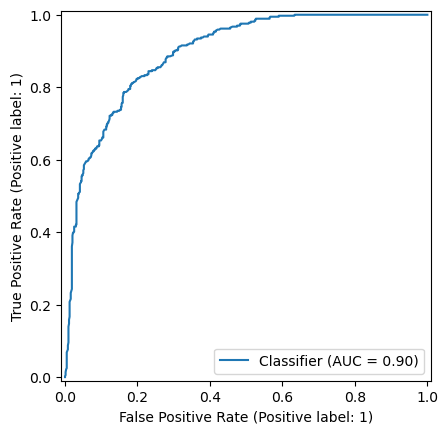

In [25]:
# --- Fast training: no hyperparameter search for debug run ---
pipe, _ = build_pipeline(train_df, y_train)

pipe.fit(X_train, y_train)

proba_test = pipe.predict_proba(X_test)[:, 1]
pred_test = (proba_test >= 0.5).astype(int)

auc = roc_auc_score(y_test, proba_test)
prec = precision_score(y_test, pred_test, zero_division=0)
rec = recall_score(y_test, pred_test, zero_division=0)

print(f"ROC-AUC   : {auc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print()
print(classification_report(y_test, pred_test, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, pred_test))

RocCurveDisplay.from_predictions(y_test, proba_test)


## Entrainement sur toutes les données (unpatched + patched)

In [27]:
# Full temporal split on the entire featurized dataset
df_full = df.sort_values(CFG.date_col).reset_index(drop=True)

train_df, test_df = temporal_train_test_split(df_full, CFG.date_col, CFG.test_size_frac)

X_train = train_df
y_train = train_df[CFG.target_col].astype(int)
X_test = test_df
y_test = test_df[CFG.target_col].astype(int)

len(train_df), len(test_df), y_train.mean()


(255280, 63820, 0.2798495769351301)

In [31]:
pipe.named_steps["clf"]

RandomForestClassifier(class_weight='balanced_subsample', n_estimators=600,
                       n_jobs=-1, random_state=42)

## RandomForestClassifier pas adpaté, on change de modèle

In [35]:
!pip install lightgbm


   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------------- -------------------------- 0.5/1.5 MB 15.2 MB/s eta 0:00:01
   ---------------------------------------  1.4/1.5 MB 18.4 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 13.2 MB/s eta 0:00:00


In [37]:
import lightgbm
from lightgbm import LGBMClassifier
lightgbm.__version__


'4.6.0'

In [39]:
pipe, _ = build_pipeline(train_df, y_train)
pipe.named_steps["clf"]


LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05, n_estimators=1200,
               n_jobs=-1, num_leaves=63, random_state=42,
               scale_pos_weight=2.5733482642777155, subsample=0.8)

[LightGBM] [Info] Number of positive: 71440, number of negative: 183840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 8.838940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1057174
[LightGBM] [Info] Number of data points in the train set: 255280, number of used features: 19729
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.279850 -> initscore=-0.945208
[LightGBM] [Info] Start training from score -0.945208
Retrieving notices: ...working... done
Channels:
 - conda-forge
 - defaults
Platform: win-64
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\lisal\anaconda3

  added / updated specs:
    - lightgbm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    boost-cpp-1.84.0           |       h6f18f0d_2          16 KB  conda-forge
    ca-certificates-2025.11.12

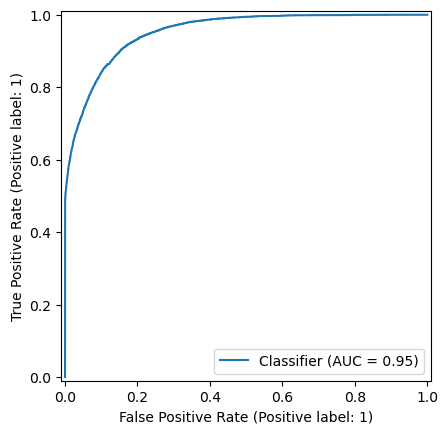

In [41]:
pipe.fit(X_train, y_train)

proba_test = pipe.predict_proba(X_test)[:, 1]
pred_test = (proba_test >= 0.5).astype(int)

auc = roc_auc_score(y_test, proba_test)
prec = precision_score(y_test, pred_test, zero_division=0)
rec = recall_score(y_test, pred_test, zero_division=0)

print(f"ROC-AUC   : {auc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}\n")
print(classification_report(y_test, pred_test, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, pred_test))
RocCurveDisplay.from_predictions(y_test, proba_test)


In [43]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test, proba_test)

# build a small table for inspection
thr_table = pd.DataFrame({
    "threshold": np.r_[thresholds, 1.0],
    "precision": precisions,
    "recall": recalls
})

thr_table.head(10), thr_table.tail(10)


(   threshold  precision  recall
 0   0.000034   0.151927     1.0
 1   0.000041   0.151930     1.0
 2   0.000043   0.151932     1.0
 3   0.000057   0.151934     1.0
 4   0.000059   0.151937     1.0
 5   0.000067   0.151939     1.0
 6   0.000073   0.151942     1.0
 7   0.000076   0.151949     1.0
 8   0.000084   0.151951     1.0
 9   0.000098   0.151953     1.0,
        threshold  precision    recall
 56990   0.999020        1.0  0.000928
 56991   0.999034        1.0  0.000825
 56992   0.999243        1.0  0.000722
 56993   0.999245        1.0  0.000619
 56994   0.999335        1.0  0.000516
 56995   0.999346        1.0  0.000413
 56996   0.999389        1.0  0.000309
 56997   0.999425        1.0  0.000206
 56998   0.999557        1.0  0.000103
 56999   1.000000        1.0  0.000000)

In [47]:
# Final training on all labeled CVEs (recommended)
pipe.fit(df, df[CFG.target_col].astype(int))

[LightGBM] [Info] Number of positive: 81136, number of negative: 237964
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 9.791002 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1114284
[LightGBM] [Info] Number of data points in the train set: 319100, number of used features: 19826
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.254265 -> initscore=-1.075993
[LightGBM] [Info] Start training from score -1.075993


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_df=0.9,
                                                                  max_features=20000,
                                                                  min_df=5,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  stop_words='english'),
                                                  'description'),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['cvss_score', 'desc_len',
                                                   'age_days', 'pub_year',
                                                   'pub_month...
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['severity', 'AV', 'AC', 'PR',
                                                   'UI', 'S', 'C', 'I',
                                                   'A'])])),
                ('clf',
                 LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05,
                                n_estimators=1200, n_jobs=-1, num_leaves=63,
                                random_state=42,
                                scale_pos_weight=2.5733482642777155,
                                subsample=0.8))])

In [49]:
# Keep only non-KEV CVEs
non_kev_df = df[df[CFG.target_col] == 0].copy()

# Predict probability of becoming KEV
non_kev_df["kev_risk_proba"] = pipe.predict_proba(non_kev_df)[:, 1]

# Show shape to confirm
non_kev_df.shape


(237964, 32)

In [62]:
# If you detected id_col earlier, use it. Otherwise, default to "cve_id".
id_col = "cve_id" if "cve_id" in non_kev_df.columns else id_col

non_kev_probs = non_kev_df[[id_col, "kev_risk_proba"]].copy()



In [64]:
# Save full ranked list to CSV
non_kev_probs.to_csv("non_kev_predicted_probs_nontrie.csv", index=False)

print("Saved to non_kev_predicted_probs.csv")


Saved to non_kev_predicted_probs.csv


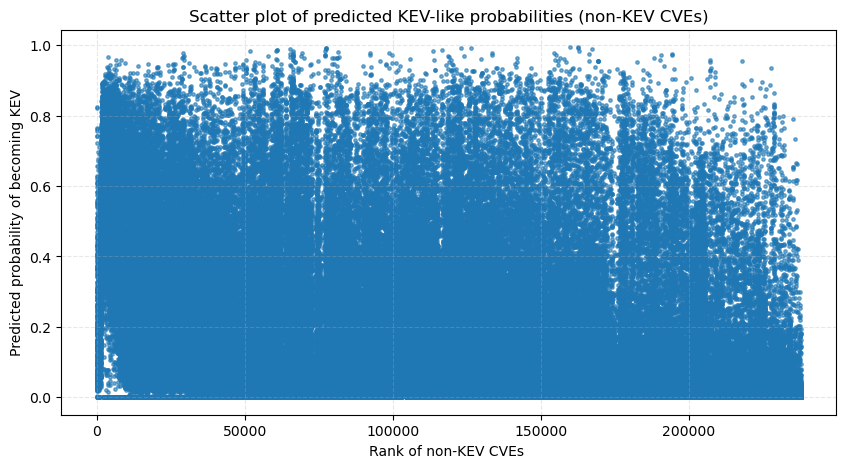

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# --- Load probabilities dataframe ---
# If non_kev_probs already exists in memory, use it.
# Otherwise, load it from the CSV you saved.
if "non_kev_probs" in globals():
    probs_df = non_kev_probs.copy()
else:
    # Change filename/path here if needed
    csv_path = Path("non_kev_predicted_probs_nontrie.csv")
    probs_df = pd.read_csv(csv_path)

# --- Ensure proper column name ---
proba_col = "kev_risk_proba"
if proba_col not in probs_df.columns:
    # fallback: assume the second column is the probability
    proba_col = probs_df.columns[1]


# x-axis = rank (0..N-1), y-axis = predicted probability
x = np.arange(len(probs_df))
y = probs_df[proba_col].values

plt.figure(figsize=(10, 5))
plt.scatter(x, y, s=6, alpha=0.6)
plt.title("Scatter plot of predicted KEV-like probabilities (non-KEV CVEs)")
plt.xlabel("Rank of non-KEV CVEs ")
plt.ylabel("Predicted probability of becoming KEV")
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()


In [72]:
probas = non_kev_probs["kev_risk_proba"]

q99 = probas.quantile(0.99)
q95 = probas.quantile(0.95)
q80 = probas.quantile(0.80)

def risk_tier(p):
    if p >= q99: return "Critical (top 1%)"
    if p >= q95: return "High (1–5%)"
    if p >= q80: return "Medium (5–20%)"
    return "Low (rest)"

non_kev_probs["risk_tier"] = probas.apply(risk_tier)
non_kev_probs["risk_tier"].value_counts()


risk_tier
Low (rest)           190370
Medium (5–20%)        35695
High (1–5%)            9519
Critical (top 1%)      2380
Name: count, dtype: int64